In [1]:
path = '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase/'
%cd '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase'

/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase


In [2]:
from dataLoaderCdiff import *
import scipy.stats as st
from collections import Counter
from ml_methods import *
import sklearn
import torch
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime

from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pubchempy as pcp
import pandas as pd
from dataLoader import *

In [3]:
dl = dataLoader(pt_perc = {'metabs': .25, '16s': .05, 'scfa': 0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0}, var_perc = {'metabs': 15, '16s': 5, 'scfa': 0})

metabs, 1st filter: (250, 1110)
metabs, 2nd filter: (250, 943)
16s, 1st filter: (231, 250)
16s, 2nd filter: (231, 237)
scfa, 1st filter: (240, 9)
scfa, 2nd filter: (240, 8)


# Get best filtering parameters

In [11]:
filt_dat = pd.read_csv('LR_local/LR_diff_filtering.csv')

In [12]:
dattypes = np.unique(filt_dat['Input data'])
df_sort = {}
for dat in dattypes:
    df_sm = filt_dat.loc[filt_dat['Input data'] == dat]
    df_sort[dat] = df_sm.sort_values(by = 'AUC', ascending = False)
    df_sort[dat].to_csv('filt_dat_' + dat + '.csv')
    

In [13]:
out = {}
for range_vals in [str((-7,2,100)), str((-4,2,100)), str((-3,3,100))]:
    for var_perc in [5,15,25]:
        dname = (range_vals, var_perc)
        ixs = set(df_sort['bile_acids'].index.values[df_sort['bile_acids']['Meas thresh'] == 0]).intersection(
            set(df_sort['bile_acids'].index.values[df_sort['bile_acids']['var perc'] == var_perc])).intersection(
            set(df_sort['bile_acids'].index.values[df_sort['bile_acids']['Range'] == range_vals]))
        aucs = list(df_sort['bile_acids'].loc[ixs]['AUC'])
        auc_med = np.median(aucs)
        out[dname] = auc_med

In [14]:
dattypes = np.unique(filt_dat['Input data'])
df_filt = {}
for dat in df_sort.keys():
    df_filt[dat] = df_sort[dat].loc[df_sort[dat]['Range'] == str((-7,2,200))]

In [14]:
num_dict = {}
for dtype in dl.keys.keys():
    dat = dl.keys[dtype]['data']
    mets = np.zeros(dat.shape)
    mets[dat > 0] = 1
    counts_all = np.sum(mets,0)

    num_dict[dtype] = {}
    for i in np.arange(min(counts_all), max(counts_all)):
        num = len(np.where(counts_all >= i)[0])
        perc = num / len(counts_all)
        num_dict[dtype][i] = perc
    print(dtype)
    print(pd.Series(num_dict[dtype]))
    print('')

metabs
1.0      1.000000
2.0      0.995674
3.0      0.991348
4.0      0.989185
5.0      0.982696
           ...   
245.0    0.230714
246.0    0.218457
247.0    0.202596
248.0    0.186734
249.0    0.162221
Length: 249, dtype: float64

16s
0.0      1.000000
1.0      0.871263
2.0      0.476684
3.0      0.352730
4.0      0.283778
           ...   
194.0    0.000797
195.0    0.000797
196.0    0.000399
197.0    0.000399
198.0    0.000399
Length: 199, dtype: float64

bile_acids
196.0    1.000000
197.0    0.985915
198.0    0.985915
199.0    0.985915
200.0    0.985915
           ...   
296.0    0.816901
297.0    0.746479
298.0    0.704225
299.0    0.647887
300.0    0.619718
Length: 105, dtype: float64

scfa
1.0      1.000000
2.0      0.888889
3.0      0.888889
4.0      0.888889
5.0      0.888889
           ...   
227.0    0.222222
228.0    0.222222
229.0    0.222222
230.0    0.222222
231.0    0.222222
Length: 231, dtype: float64



In [17]:
pd.DataFrame(num_dict).to_csv('/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/zero_inflation.csv')

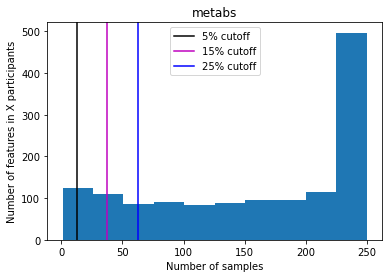

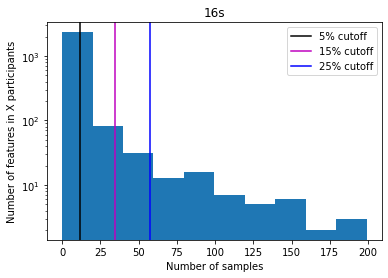

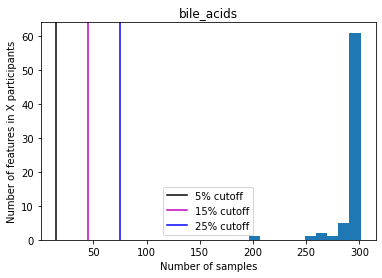

In [48]:
for dtype in dl.keys.keys():
    plt.figure()
    dat = dl.keys[dtype]['data']

    mets = np.zeros(dat.shape)
    mets[dat > 0] = 1
    counts_all = np.sum(mets,0)
    plt.hist(counts_all)

    a = plt.axvline(.05*mets.shape[0], color = 'k')
    b = plt.axvline(.15*mets.shape[0], color = 'm')
    c = plt.axvline(.25*mets.shape[0], color = 'b')
    plt.title(dtype)
    plt.xlabel('Number of samples')
    plt.ylabel('Number of features in X participants')
    if dtype == '16s':
        plt.yscale('log')
    plt.legend([a,b,c],['5% cutoff','15% cutoff','25% cutoff'])
    plt.show()

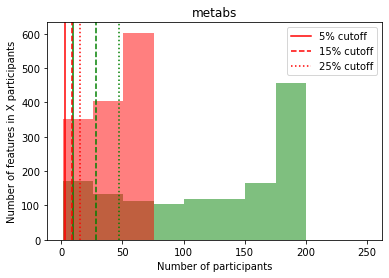

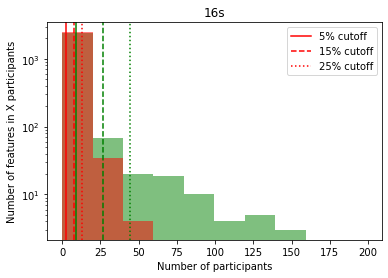

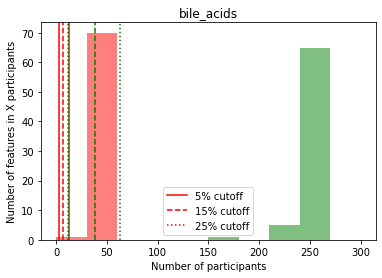

In [66]:
colors = {'Recur':'r', 'Cleared':'g'}
for dtype in dl.keys.keys():
    plt.figure()
    dat = dl.keys[dtype]['data']
    if dtype == 'bile_acids':
        targs = dl.keys[dtype]['targets'].drop(labels = 'Study Pool Sample')
    else:
        targs = dl.keys[dtype]['targets']
    mets = np.zeros(dat.shape)
    mets[dat > 0] = 1
    counts_all = np.sum(mets,0)
    counts_all[counts_all > 300] = 0
    bins = np.histogram(counts_all)[1]
    for lab in np.unique(targs):
        mets_1 = mets[np.where(targs == lab)[0],:]
        met_counts = np.sum(mets_1, 0)
        plt.hist(met_counts, color = colors[lab], label = lab, bins = bins, alpha = 0.5)
        perc = .05*mets_1.shape[0]
        a = plt.axvline(.05*mets_1.shape[0], color = colors[lab], linestyle = '-')
        b = plt.axvline(.15*mets_1.shape[0], color = colors[lab], linestyle = '--')
        c = plt.axvline(.25*mets_1.shape[0], color = colors[lab], linestyle = ':')
    plt.title(dtype)
    plt.xlabel('Number of participants')
    plt.ylabel('Number of features in X participants')
    if dtype == '16s':
        plt.yscale('log')
    plt.legend([a,b,c],['5% cutoff','15% cutoff','25% cutoff'])
    plt.show()

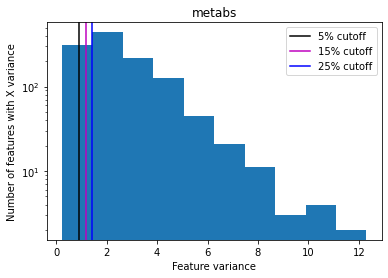

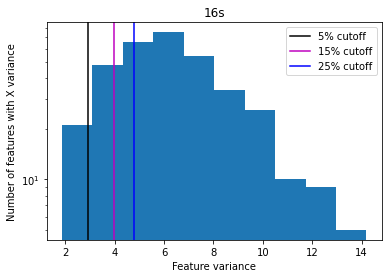

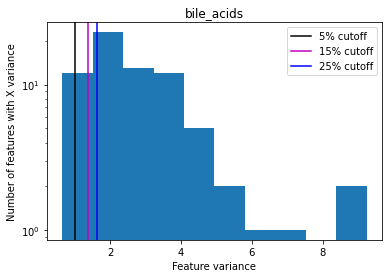

In [47]:
colors = {'Recur':'r', 'Cleared':'g'}
perc = {'metabs': .25, '16s': .05, 'bile_acids': .25}
for dtype in dl.keys.keys():
    plt.figure()
    dat = filter_by_pt(dl.keys[dtype]['data'], dl.keys[dtype]['targets'], perc = perc[dtype])

    total_vars = np.std(dat,0)/np.abs(np.mean(dat,0))
    total_vars = total_vars.replace(np.nan,0)
    plt.hist(total_vars)
    a = plt.axvline(np.percentile(total_vars, 5), c = 'k')
    b = plt.axvline(np.percentile(total_vars, 15), c = 'm')
    c = plt.axvline(np.percentile(total_vars, 25), c = 'b')
    plt.legend([a,b,c],['5% cutoff','15% cutoff','25% cutoff'])
    plt.xlabel('Feature variance')
    plt.ylabel('Number of features with X variance')
    plt.yscale('log')
    plt.title(dtype)
    plt.show()

